In [1]:
%cd /scratch/noah/dalma/

/scratch/noah/dalma


In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/scratch/noah/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:810: UserWarning: Found matplotlib configuration in ~/.matplotlib/. To conform with the XDG base directory standard, this configuration location has been deprecated on Linux, and the new location is now /home/noah/.config/matplotlib/. Please move your configuration there to ensure that matplotlib will continue to find it in the future.
  _get_xdg_config_dir())


In [3]:
import matplotlib.pyplot as plt

from gnl.plots import *
from gnl.xarray import *

In [4]:
import os

if not os.path.exists("./WALKER_2km_4096x1_64_2000m_15s.WALKER_2K_32.mean.nc"):

    !scp dalma:/scratch/ndb245/SAM6.10.9/OUT_3D/WALKER_2km_4096x1_64_2000m_15s.WALKER_2K_32.mean.nc .

In [5]:
data = xr.open_dataset("./WALKER_2km_4096x1_64_2000m_15s.WALKER_2K_32.mean.nc")
data

<xarray.Dataset>
Dimensions:  (time: 1, x: 4096, z: 64)
Coordinates:
  * x        (x) float32 0.0 2000.0 4000.0 6000.0 8000.0 10000.0 12000.0 ...
  * z        (z) float32 37.5 112.5 194.04 288.08 395.37 520.11 667.48 ...
  * time     (time) float32 9.41667
Data variables:
    p        (z) float32 1010.73 1002.25 993.084 982.595 970.733 957.079 ...
    U        (time, z, x) float32 -0.00277632 0.000221861 -0.0923446 ...
    V        (time, z, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    W        (time, z, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    PP       (time, z, x) float32 144.021 143.97 143.348 143.092 143.679 ...
    QRAD     (time, z, x) float32 -2.05552 -2.16562 -2.06683 -2.13914 ...
    TABS     (time, z, x) float32 296.542 296.541 296.537 296.533 296.541 ...
    QV       (time, z, x) float32 12.1765 12.2111 12.212 12.1742 12.2017 ...
    QN       (time, z, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    QP       (time, z, x) float32 0.0

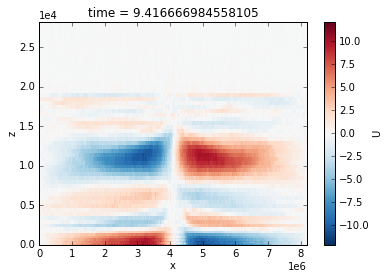

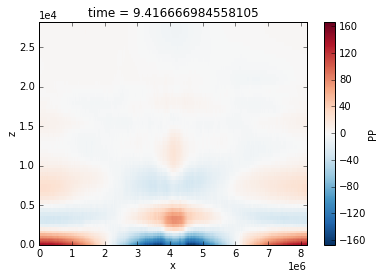

In [6]:
U = data.U.squeeze()
U.plot()
plt.figure()
data.PP.plot()

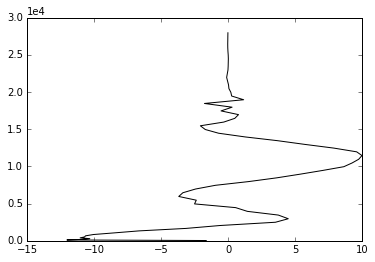

In [7]:
plt.plot(U.sel(x=5e6), data.z)

In [8]:
psurf = 1000
ptop= 150
p = data.p.values
vertical_modes=  [xr.DataArray(cos((p - psurf) * pi  * m / (psurf-ptop)) * (p < psurf) * (p > ptop),
                          dims= ['p'],
                          coords=dict(p=p),
                          attrs=dict(mode=m))
                          for m in range(4)]

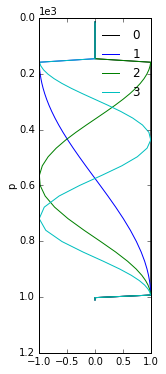

In [9]:
plt.figure(figsize=(2,6))
for i, v in enumerate(vertical_modes):

    plot(v, v.p, label=i)
gca().invert_yaxis()
ylabel('p')
legend()

In [10]:
def redim(U, data):
    
    return xr.DataArray(U.squeeze(), dims=('p', 'x'), coords={k:data[k].values for k in ['p', 'x']})

In [11]:
Up = redim(data.U, data)

In [12]:
modes = [-integrate(Up * mode, 'p') for mode in vertical_modes]

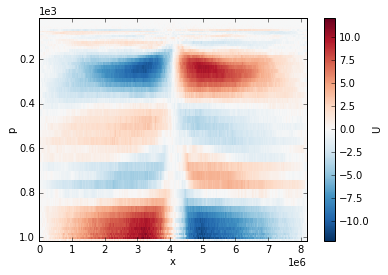

In [13]:
Up.plot()
plt.gca().invert_yaxis()

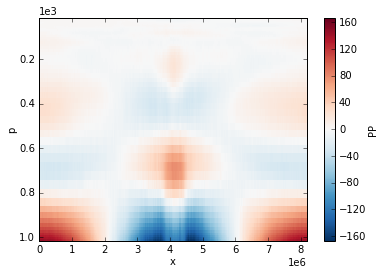

In [14]:
PPp = redim(data.PP, data)
PPp.plot()
plt.gca().invert_yaxis()

The third baroclinic velocity structure seems to be driven by the pressure gradient. Which indicates that the apparent heating is projecting strongly on the third baroclinic mode, which is then driving the pressure gradient. Moreover the sign of the velocity field is the opposite of what would be expected from the transports due to a tilted travelling wave.

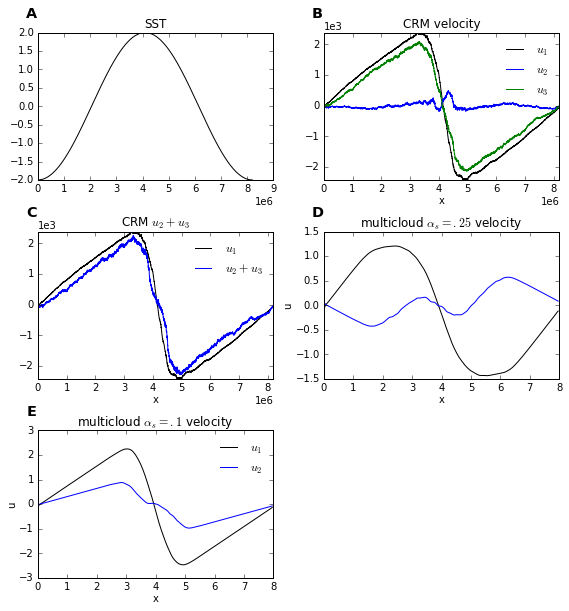

In [37]:
pt= plotiter(['SST', 
              'CRM velocity',
            r'CRM $u_2 + u_3$',
              r'multicloud $\alpha_s=.25$ velocity',
              r'multicloud $\alpha_s=.1$ velocity'],w=4, aspect=.7, ncol=2)

title=next(pt)
x=  data.x
y = -cos(x/x.max() * 2*pi) * 2 

plt.plot(x,y)
plt.title(title)

title = next(pt)

for i, mode in enumerate(modes[1:]):
    mode.plot(label=r'$u_{}$'.format(i+1))

plt.axis('tight')
plt.title(title)
plt.legend()

title= next(pt)
modes[1].plot(label=r'$u_1$')
(modes[2]+ modes[3]).plot(label='$u_2 + u_3$')

plt.axis('tight')
plt.title(title)
plt.legend()

title = next(pt)

stratmc = xr.open_dataset("/home/noah/workspace/multicloudstochfmk13/examples/warmpool/out.nc")

for i in [1,2]:
    stratmc.u.squeeze().mean('time').sel(m=i).plot(label=r'$u_{}$'.format(i))
plt.title(title)

    
title = next(pt)

conmc = xr.open_dataset("/home/noah/workspace/multicloudstochfmk13/examples/warmpool_cong/out.nc")

for i in [1,2]:
    conmc.u.squeeze().mean('time').sel(m=i).plot(label=r'$u_{}$'.format(i))
plt.title(title)

legend()

plt.tight_layout()

It appears that strongest contributers to the climatology are modes 1 and 3. But there is a systematic behavior of 

The second baroclinic mode does seems to show a different sign to the mode 1 divergence field. This is the opposite is expected from stratiform dominated heating. And shows that congesuts heating dominates in the warm pool.

$$ -\partial_x u_2 = H_c - H_s $$

So if $H_s > H_c$, then $\partial_x u_2 > 0$. This seems to be the case only in the very center of the warm pool. And not in the edges. So shallow convection should tend to dominate in the edges. This is opposite of the climatology that is seen in the stratiform dominated case in the multicloud model.

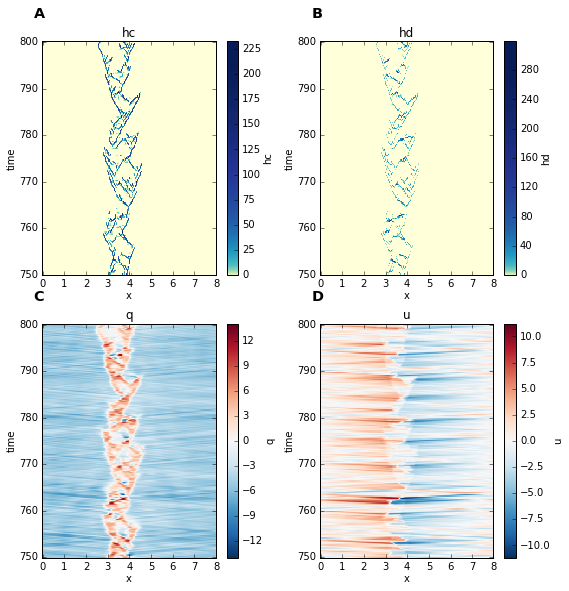

In [84]:
pdata = conmc.sel(time=slice(750, None))


for v in plotiter([pdata.hc, 
                   pdata.hd, 
                   pdata.q, 
                   pdata.u.sel(m=1)], w=4, ncol=2):
    
    if v.name in ['hc', 'hd']:
        v.plot(cmap='YlGnBu', norm=LogP1(base=v.values.max()*.9))
    else:
        v.plot()
    plt.title(v.name)